PPCA lavora con più variabili osservabili anzichè una sola

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import aesara.tensor as at
import arviz as az
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from scipy import stats
import scipy
import pandas as pd

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
scaler = StandardScaler()

In [3]:
#data = np.load('prova.npy', allow_pickle=True).item()

# extract data social anxiety

In [4]:
#csv_ = '/Users/marcoghezzi/PycharmProjects/pythonProject/osfstorage-archive/behavior/LookAtMe_002.csv'
csv_ = '/home/paolo/matteo/matteo/unimi/tesi_master/code/osfstorage-archive/behavior/LookAtMe_002.csv'
global_data = pd.read_csv(csv_, sep='\t')
y = np.array(list([int(d>2) for d in global_data['rating']]))
e_labels = y[:,np.newaxis]  # rating > 2

In [5]:
print(len(e_labels))

160


In [6]:
N_e = e_labels.shape[0]
D_e = e_labels.shape[1]
print(N_e,D_e)

160 1


## test with new data

In [7]:
import deepemogp.feature_extractor as feature_extractor
import deepemogp.signal.physio as physio
import deepemogp.signal.face as face
import deepemogp.signal.annotation as annotation
import deepemogp.datasets as datasets
import deepemogp.signal.behavior as behavior

# from: https://github.com/SheffieldML/GPy
#import GPy
# from: https://github.com/SheffieldML/PyDeepGP
#import deepgp

import pandas as pd
import numpy as np

show = False
# definition of the feature extractors to be used later
f2 = feature_extractor.FE('wavelet', window=(2, 1))
f3 = feature_extractor.FE('mean', window=(1,0))

# definition of the physiological signals to be extracted
eda_ = physio.EDA(f2)
hr_ = physio.HR(f2)
pupil_ = behavior.PUPIL(f3)

# definition of the emotional annotation to be extracted
#va = annotation.VA('valence', f3)
#ar = annotation.VA('arousal', f3)
# extraction of the desired data from the dataset
d = datasets.FEAR(signals={hr_,pupil_,eda_}, subjects={'2'})

for s in d.signals:
    # preprocess ...
    if s.name =='EDA':
        s.preprocess(show=show,new_fps=500)
        s.feature_ext.extract_feat(s,show=show)
    else:
        s.feature_ext.extract_feat_without_preprocess(s, show=show)

    #add feature extraction for eda before preprocessing

    # ... and extract features from each signal type


for sig in d.signals:
    if sig.name=='EDA':
        eda_data = sig.features
    if sig.name=='HR':
        hr_data = sig.features
    if sig.name=='PUPIL':
        pupil_data = sig.features

>> Loading HR for subject 2 and all sessions from dataset FEAR
>> Loading EDA for subject 2 and all sessions from dataset FEAR
>> Loading PUPIL for subject 2 and all sessions from dataset FEAR
>> Extracting wavelet features from HR signal, adopting (2, 1) window ...
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
params: 
1000
param

In [8]:
'''for sig in d.signals:
    print (sig.name)
    print (sig.features)'''

'for sig in d.signals:\n    print (sig.name)\n    print (sig.features)'

In [9]:
list(d.signals)[0].name
d.signals

{<deepemogp.signal.physio.eda.EDA at 0x7fb4bd722ac0>,
 <deepemogp.signal.behavior.pupil.PUPIL at 0x7fb4a9fcfbe0>}

In [10]:
np.array(hr_data)

array([[-0.64188783, -0.68497159, -0.64642643, ..., -1.36232328,
         0.46433581,  0.489405  ],
       [-1.00544987, -1.43820783, -1.54146452, ...,  0.51984375,
         0.68324008, -0.98227022],
       [ 1.05486422,  1.00036774,  0.80219155, ...,  0.74046552,
        -0.97399816, -0.45701132],
       ...,
       [-0.81613236, -0.89156174, -1.08158321, ..., -0.60326427,
         0.67988462, -2.75543333],
       [-0.80968483, -0.82132205, -0.82065559, ...,  0.07854003,
         0.9353287 , -1.74339795],
       [-2.30642018, -2.28780647, -2.46136754, ...,  0.76230065,
        -0.38713393, -0.909278  ]])

In [11]:
TRIAL = 160

In [12]:
hr =np.array(hr_data)
hr = hr.reshape((TRIAL, int(hr.shape[0]/TRIAL*hr.shape[1])))
hr

array([[-0.64188783, -0.68497159, -0.64642643, ...,  0.15621747,
         0.80186078, -1.17837803],
       [-0.62331059, -0.60911192, -0.35912484, ...,  0.54332166,
        -0.46717233, -0.89322544],
       [ 2.65622776,  2.74034822,  2.89820358, ..., -0.37652224,
         0.47642237,  0.94254597],
       ...,
       [-0.55806097, -0.60984793, -0.51304214, ...,  0.09806073,
         0.12308417, -1.07480292],
       [-1.01631131, -1.0172051 , -1.02552677, ..., -0.54214066,
         0.64236454, -2.13375278],
       [ 1.88518587,  1.9495498 ,  2.07482153, ...,  0.76230065,
        -0.38713393, -0.909278  ]])

In [13]:
pupil = np.array(pupil_data)
pupil = pupil.reshape((TRIAL, int(pupil.shape[0]/TRIAL*pupil.shape[1])))
pupil

array([[2.27416564, 2.245639  , 2.20375466, 2.18616776, 2.27428793],
       [2.21362728, 2.20769547, 2.16418199, 2.18038316, 2.27493701],
       [2.33877423, 2.31771184, 2.20056014, 2.23447353, 2.4237714 ],
       [2.32541712, 2.32568158, 2.25262441, 2.24006634, 2.24798944],
       [2.20656788, 2.2175642 , 2.19622616, 2.1363718 , 2.2510569 ],
       [2.27959204, 2.23140624, 2.19588528, 2.15571552, 2.2671253 ],
       [2.29152457, 2.2058622 , 2.12755255, 2.21195818, 2.29039822],
       [2.22358358, 2.18235154, 2.16830625, 2.16702894, 2.18362694],
       [2.21214013, 2.24347525, 2.24118098, 2.16817266, 2.22973327],
       [2.23261497, 2.24981787, 2.26733249, 2.2683871 , 2.07300613],
       [2.14128236, 2.0935333 , 2.08974901, 1.98326707, 2.0701649 ],
       [2.21034149, 2.16100416, 2.15033919, 2.05387229, 2.13022971],
       [2.25740095, 2.25297688, 2.23617017, 2.18118711, 2.33014982],
       [2.16942032, 2.16678353, 2.13962532, 2.09908136, 2.22264389],
       [2.22865397, 2.22836955, 2.

In [14]:
eda = np.array(eda_data)
eda = eda.reshape((TRIAL,int(eda.shape[0]/TRIAL*eda.shape[1])))
eda

array([[ 1.97898690e-01,  2.00012707e-01,  1.75507604e-01, ...,
         4.81298913e+01,  4.60267422e+01,  4.42350275e+01],
       [-5.53816308e-02, -5.57764524e-02, -4.36125510e-02, ...,
         1.78870234e+01,  2.05569489e+01,  2.18692781e+01],
       [ 4.42685728e-01,  4.45850861e-01,  3.49055310e-01, ...,
         8.98436011e+00,  8.15463754e+00,  7.45112397e+00],
       ...,
       [ 5.23055152e-01,  5.27481000e-01,  4.31494797e-01, ...,
         1.85656127e+01,  1.68753187e+01,  1.53772666e+01],
       [ 6.89305670e-01,  6.95911831e-01,  5.90206239e-01, ...,
         7.62950238e+00,  7.31481086e+00,  7.07995644e+00],
       [ 9.12873487e-02,  9.18700474e-02,  7.00183309e-02, ...,
         3.20690758e+01,  4.30562385e+01,  4.85037550e+01]])

## end test

prendo un'implementazione di sppca e la applico al nostro caso

different types of observable data

1) gaze
2) fisio
    2.1) heart rate variability
    2.2) eda phasic value
3) social anxiety
4) aspettativa del dolore

In [15]:

'''social_anx = data['social anxiety'][:,np.newaxis]
pain_exp = data['pain expectation'][:,np.newaxis]'''


"social_anx = data['social anxiety'][:,np.newaxis]\npain_exp = data['pain expectation'][:,np.newaxis]"

In [16]:
print(pupil.shape)
print(hr.shape)
print(eda.shape)

(160, 5)
(160, 60)
(160, 60)


In [17]:
N_pupil = pupil.shape[0]
D_pupil = pupil.shape[1]

N_hr = hr.shape[0]
D_hr = hr.shape[1]

N_eda = eda.shape[0]
D_eda = eda.shape[1]
K = 1

print(N_pupil,D_pupil)
print(N_hr,D_hr)
print(N_eda,D_eda)
print(N_e, D_e)

160 5
160 60
160 60
160 1


In [20]:
import theano.tensor as tt

In [23]:
with pm.Model() as sPPCA:
    #dati osservabili
    hr_data = pm.Data("hr_data", hr.T)
    pupil_data = pm.Data("pupil_data", pupil.T)
    eda_data = pm.Data("eda_data", eda.T)

    e_data = pm.Data("e_data", e_labels.T)

    #matrici pesi
    Whr = pm.Normal('Whr', mu=tt.zeros([D_hr, K]), sd=2.0 * tt.ones([D_hr, K]), shape=[D_hr, K])
    Wpupil = pm.Normal('Wpupil', mu=tt.zeros([D_pupil, K]), sd=2.0 * tt.ones([D_pupil, K]), shape=[D_pupil, K])

    Weda = pm.Normal('Weda', mu=tt.zeros([D_eda, K]), sd=2.0 * tt.ones([D_eda, K]), shape=[D_eda, K])

    #weight matrix for pain expectation.
    #check mu,sigma,shape
    We = pm.Normal('W_e', mu=tt.zeros([D_e, K]), sd=2.0 * tt.ones([D_e,K]), shape=[D_e, K])

    #latent space
    c = pm.Normal('c', mu=tt.zeros([N_hr,K]), sd=tt.ones([N_hr,K]), shape=[N_hr,K])

    # dati dell'hrv interpretati come una gaussiana
    x_hr = pm.Normal('x_hr', mu=Whr.dot(c.T), sd=tt.ones([D_hr,N_hr]) ,shape=[D_hr, N_hr], observed=hr_data)
    # dati della dilatazione pupille interpretati come una gaussiana
    x_pupil = pm.Normal('x_pupil', mu=Wpupil.dot(c.T), sd=tt.ones([D_pupil, N_pupil]), shape=[D_pupil, N_pupil], observed=pupil_data)
    #eda
    x_eda = pm.Normal('x_eda',mu=Weda.dot(c.T),sd= tt.ones([D_eda,N_pupil]), shape=[D_eda,N_eda], observed=eda_data)

    # pain expectation. ciò che dovremmo inferire dato c
    # due strade: binary o multiclass (1-4)
    # p = probability of success?
    x_e = pm.Bernoulli('x_e' , p=pm.math.sigmoid(We.dot(c.T)) , shape =[D_e, N_e], observed=e_data)

    #x_hr = pm.Bernoulli('x_hr', p=pm.math.sigmoid(Whr.dot(c.T)), shape=[D_hr, N_hr], observed=hr_data)
    #x_eda = pm.Bernoulli('x_eda', p=pm.math.sigmoid(Weda.dot(c.T)), shape=[D_eda, N_eda], observed=eda_data)

In [25]:
gv = pm.model_to_graphviz(sPPCA)
gv.view()

'.gv.pdf'

In [26]:
sPPCA.free_RVs

[Whr ~ Normal, Wpupil ~ Normal, Weda ~ Normal, W_e ~ Normal, c ~ Normal]

In [27]:
with sPPCA:
    trace = pm.sample(1000,init='advi+adapt_diag',chains=1,progressbar=True,target_accept=0.95)

/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 40900
Interrupted at 40,899 [20%]: Average Loss = 4.7818e+05
Sequential sampling (1 chains in 1 job)
NUTS: [c, W_e, Weda, Wpupil, Whr]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 276 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Got error No model on context stack. trying to find log_likelihood in translation.
/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


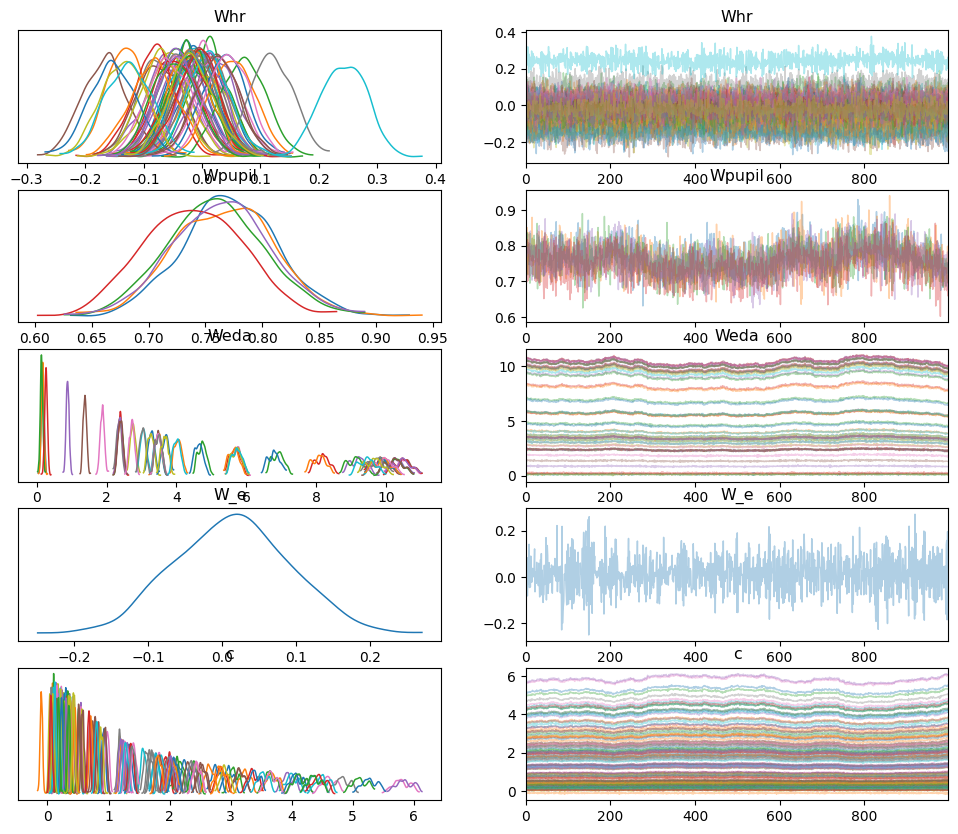

In [28]:
#az.plot_posterior(mean_field.sample(1000), color="LightSeaGreen")
az.plot_trace(trace)
plt.show()

In [29]:
with sPPCA:
    # update values of predictors:
    pm.set_data({"pupil_data": pupil,"hr_data":hr,"eda_data":eda})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, random_seed=123)

In [31]:
e_pred = posterior_predictive["x_e"]

In [32]:
e_pred

array([[[1, 1, 1, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 1, 0, 1]],

       [[1, 0, 1, ..., 0, 0, 1]],

       ...,

       [[0, 1, 1, ..., 1, 0, 0]],

       [[0, 1, 1, ..., 1, 1, 0]],

       [[1, 1, 0, ..., 1, 1, 0]]])

In [33]:
e_pred_mode = np.squeeze(stats.mode(e_pred[0], keepdims=False)[0])[:,np.newaxis]

In [34]:
e_pred_mode

array([[1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
    

In [35]:
e_labels

array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
    

In [36]:
train_accuracy_exp = accuracy_score(e_labels, e_pred_mode)
print('\n\tTrain Accuracy Pain Expectation: ' + str(train_accuracy_exp))
print(' ')


	Train Accuracy Pain Expectation: 0.5
 


--------------------------------------------------------------------------------------------

In [30]:
hr_pred_mean = (stats.median_abs_deviation(hr_pred[0]))[0]
hr_pred_mean

NameError: name 'hr_pred' is not defined

In [ ]:
hr[0]

In [ ]:
#hr_pred_mode= pd.Series([0.006,0.01,0.02,0.003])

hr and hr_pred_mode devono avere same shape

In [ ]:
train_accuracy_hr = (np.subtract(hr[0], hr_pred_mean))
print('\n\t avg distance hr: \n' + str(train_accuracy_hr))
#print(' ')

In [ ]:
with sPPCA:
    # update values of predictors:
    pm.set_data({"hr_data": hr})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, random_seed=123)
    gaze_pred = posterior_predictive.posterior_predictive["x_gaze"]

In [ ]:
gaze_pred

In [ ]:
gaze_pred_mean = np.mean(gaze_pred, axis=0).T.reshape(-1)
gaze_true = pupil.reshape(-1)
reconstructed_r2 = metrics.r2_score(gaze_true, gaze_pred_mean)

print('\n\tReconstructed X R2 score: ' + str(reconstructed_r2))

In [ ]:
import deepemogp.feature_extractor as feature_extractor

In [ ]:
f = feature_extractor.FE('wavelet', window=(8,6), params={'w_mother':'db3','w_maxlev':1})

In [ ]:
x = [3, 7, 1, 1, -2, 5, 4, 6]

In [ ]:
f.apply(x)